# Data Information

### Attribute information:

Input variables:
- age (numeric)
- job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student","blue-collar","self-employed","retired","technician","services") 
- marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
- education (categorical: "unknown","secondary","primary","tertiary")
- default: has credit in default? (binary: "yes","no")
- balance: average yearly balance, in euros (numeric) 
- housing: has housing loan? (binary: "yes","no")
- loan: has personal loan? (binary: "yes","no")
- contact: contact communication type (categorical: "unknown","telephone","cellular")
- day: last contact day of the month (numeric)
- month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
- duration: last contact duration, in seconds (numeric)
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")
   
Output variable (desired target):
- y: has the client subscribed a term deposit? (binary: "yes","no")

# Importing Libraries and Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import scipy.stats as stats
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
sns.set()
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("processed-data.csv")

In [3]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,not applicable,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,not applicable,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,not applicable,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,not applicable,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,not applicable,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,not applicable,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,not applicable,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,not applicable,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


# Preprocessing

### Converting to categorical

In [5]:
# Converting all object variables to categorical variables

cols = ['job', 'marital', 'education', 'default', 'housing',
       'loan', 'contact', 'month', 'poutcome', 'y']

for col in cols:
    df[col] = df[col].astype('category')

### Changing y to binary

In [6]:
# changing y to binary - 0 and 1
ymap = {'no': 0, 'yes': 1}

df.replace({'y':ymap}, inplace = True)

### Dummy variables

In [7]:
X = df.drop(['y'], axis=1)
y = df['y']

X = pd.get_dummies(X, columns=['job', 'marital', 'education', 'default', 'housing',
       'loan', 'contact', 'month', 'poutcome'], drop_first=True)

### Splitting the dataset

In [8]:
#Splitting data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 1, stratify=y)

In [9]:
y_train.value_counts(1)

0    0.883022
1    0.116978
Name: y, dtype: float64

In [10]:
y_test.value_counts(1)

0    0.882999
1    0.117001
Name: y, dtype: float64

#### The splits are quite balanced in terms of 1s and 0s.

# Model Evaluation Criteria

#### The incorrect predictions are the following:
- Customer predicted to buy, but actually doesn't buy (Type I).
- Customer predicted to not buy, but actually buys (Type II).
<br><br>
The more costly error is the type II error, as the bank would not market the product to this customer, and fail to make a sale because the customer would have in reality bought the product.<br><br>
Type I errors will make the bank focus on customers that would not buy the product, so it is not too much of a cost except for the time and effort put into these customers.

#### Therefore, we will need to identify as much potential customers as possible, so recall will be the ideal metric to use for evaluation.

#### Note: I will be using 0.05 as the value of alpha

### Creating functions to calculate metrics

In [11]:
##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_metrics_score(model,train,test,train_y,test_y,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    
    score_list=[] 
    
    pred_train = model.predict(train)
    pred_test = model.predict(test)
    
    pred_train = np.round(pred_train)
    pred_test = np.round(pred_test)
    
    train_acc = accuracy_score(pred_train,train_y)
    test_acc = accuracy_score(pred_test,test_y)
    
    train_recall = recall_score(train_y,pred_train)
    test_recall = recall_score(test_y,pred_test)
    
    train_precision = precision_score(train_y,pred_train)
    test_precision = precision_score(test_y,pred_test)
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))
        
   # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    
    if flag == True: 
        print("Accuracy on training set : ",accuracy_score(pred_train,train_y))
        print("Accuracy on test set : ",accuracy_score(pred_test,test_y))
        print("Recall on training set : ",recall_score(train_y,pred_train))
        print("Recall on test set : ",recall_score(test_y,pred_test))
        print("Precision on training set : ",precision_score(train_y,pred_train))
        print("Precision on test set : ",precision_score(test_y,pred_test))
    return score_list # returning the list with train and test scores

In [12]:
## Function to create confusion matrix
def make_confusion_matrix(model,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(X_test)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (9,6))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Model Building

#### I will create the following models:
- Linear Regression Model
- Decision Tree Model
- Random Forest Model
- Gradient Boost Model
- XGBoost Model
- Stacking Classifier

<br> I will also use GridSearch and RandomSearch to find even better models.

## Logistic Regression

### Checking for multicollinearity

In [13]:
# Creating a copy of the X_train and adding a constant
num_feature_set = X_train.copy()
num_feature_set = add_constant(num_feature_set)
num_feature_set = num_feature_set.astype(float)

In [14]:
# Checking VIF scores

vif_series1 = pd.Series([variance_inflation_factor(num_feature_set.values,i) for i in range(num_feature_set.shape[1])],index=num_feature_set.columns, dtype = float)
print('Series before feature selection: \n\n{}\n'.format(vif_series1))

Series before feature selection: 

const                      127.276285
age                          1.732468
balance                      1.053588
day                          1.344094
duration                     1.019660
campaign                     1.122336
pdays                        4.687674
previous                     1.689970
job_blue-collar              2.496573
job_entrepreneur             1.308116
job_housemaid                1.283562
job_management               3.017224
job_retired                  1.716929
job_self-employed            1.317499
job_services                 1.639845
job_student                  1.253499
job_technician               2.113486
job_unemployed               1.245403
job_unknown                  1.095869
marital_married              2.552594
marital_single               2.908381
education_secondary          2.619853
education_tertiary           3.402284
education_unknown            1.310971
default_yes                  1.014731
housing_yes    

#### There are no features that show multicollinearity, which is great. We can now proceed to building the model.

### Creating model

In [15]:
# adding constant to training and test set

X_train_lg = sm.add_constant(X_train)
X_test_lg = sm.add_constant(X_test)

In [16]:
logit = sm.Logit(y_train, X_train_lg)

lg = logit.fit()

print(lg.summary2())

Optimization terminated successfully.
         Current function value: 0.236500
         Iterations 8
                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.345     
Dependent Variable:    y                  AIC:                15055.0485
Date:                  2021-08-13 23:19   BIC:                15414.6317
No. Observations:      31647              Log-Likelihood:     -7484.5   
Df Model:              42                 LL-Null:            -11420.   
Df Residuals:          31604              LLR p-value:        0.0000    
Converged:             1.0000             Scale:              1.0000    
No. Iterations:        8.0000                                           
------------------------------------------------------------------------
                         Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------
const                   -2.7602   0.2238 -12.3317 0

In [17]:
metrics_lg = get_metrics_score(lg,X_train_lg,X_test_lg,y_train,y_test,flag=True)

Accuracy on training set :  0.9033715676051443
Accuracy on test set :  0.8998083161309348
Recall on training set :  0.3565640194489465
Recall on test set :  0.3408947700063012
Precision on training set :  0.6613226452905812
Precision on test set :  0.6334894613583139


#### The accuracy is quite high, with no overfitting, but recall is very low. I will start dropping insignificant variables.

In [18]:
X_train_lg2 = X_train_lg.drop('age', axis=1)
X_test_lg2 = X_test_lg.drop('age', axis=1)

In [19]:
logit = sm.Logit(y_train, X_train_lg2)

lg2 = logit.fit()

print(lg2.summary2())

Optimization terminated successfully.
         Current function value: 0.236517
         Iterations 8
                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.345     
Dependent Variable:    y                  AIC:                15054.0817
Date:                  2021-08-13 23:19   BIC:                15405.3024
No. Observations:      31647              Log-Likelihood:     -7485.0   
Df Model:              41                 LL-Null:            -11420.   
Df Residuals:          31605              LLR p-value:        0.0000    
Converged:             1.0000             Scale:              1.0000    
No. Iterations:        8.0000                                           
------------------------------------------------------------------------
                         Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------
const                   -2.8889   0.1847 -15.6402 0

In [20]:
metrics_lg = get_metrics_score(lg2,X_train_lg2,X_test_lg2,y_train,y_test,flag=True)

Accuracy on training set :  0.903245173318166
Accuracy on test set :  0.9002506635210852
Recall on training set :  0.3571042679632631
Recall on test set :  0.34341524889729047
Precision on training set :  0.6596806387225549
Precision on test set :  0.6366822429906542


#### No improvement

In [21]:
X_train_lg3 = X_train_lg2.drop('default_yes', axis=1)
X_test_lg3 = X_test_lg2.drop('default_yes', axis=1)

In [22]:
logit = sm.Logit(y_train, X_train_lg3)

lg3 = logit.fit()

print(lg3.summary2())

Optimization terminated successfully.
         Current function value: 0.236520
         Iterations 8
                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.345     
Dependent Variable:    y                  AIC:                15052.2846
Date:                  2021-08-13 23:19   BIC:                15395.1430
No. Observations:      31647              Log-Likelihood:     -7485.1   
Df Model:              40                 LL-Null:            -11420.   
Df Residuals:          31606              LLR p-value:        0.0000    
Converged:             1.0000             Scale:              1.0000    
No. Iterations:        8.0000                                           
------------------------------------------------------------------------
                         Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------
const                   -2.8888   0.1847 -15.6396 0

In [23]:
metrics_lg = get_metrics_score(lg3,X_train_lg3,X_test_lg3,y_train,y_test,flag=True)

Accuracy on training set :  0.903245173318166
Accuracy on test set :  0.9001769389560602
Recall on training set :  0.3571042679632631
Recall on test set :  0.3427851291745432
Precision on training set :  0.6596806387225549
Precision on test set :  0.6362573099415205


In [24]:
X_train_lg4 = X_train_lg3.drop('pdays', axis=1)
X_test_lg4 = X_test_lg3.drop('pdays', axis=1)

In [25]:
logit = sm.Logit(y_train, X_train_lg4)

lg4 = logit.fit()

print(lg4.summary2())

Optimization terminated successfully.
         Current function value: 0.236549
         Iterations 8
                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.344     
Dependent Variable:    y                  AIC:                15052.1267
Date:                  2021-08-13 23:19   BIC:                15386.6226
No. Observations:      31647              Log-Likelihood:     -7486.1   
Df Model:              39                 LL-Null:            -11420.   
Df Residuals:          31607              LLR p-value:        0.0000    
Converged:             1.0000             Scale:              1.0000    
No. Iterations:        8.0000                                           
------------------------------------------------------------------------
                         Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------
const                   -2.7653   0.1605 -17.2259 0

In [26]:
metrics_lg = get_metrics_score(lg4,X_train_lg4,X_test_lg4,y_train,y_test,flag=True)

Accuracy on training set :  0.903245173318166
Accuracy on test set :  0.9004718372161604
Recall on training set :  0.35602377093462995
Recall on test set :  0.3427851291745432
Precision on training set :  0.6603206412825652
Precision on test set :  0.6392479435957696


In [27]:
X_train_lg5 = X_train_lg4.drop('previous', axis=1)
X_test_lg5 = X_test_lg4.drop('previous', axis=1)

In [28]:
logit = sm.Logit(y_train, X_train_lg5)

lg5 = logit.fit()

print(lg5.summary2())

Optimization terminated successfully.
         Current function value: 0.236586
         Iterations 8
                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.344     
Dependent Variable:    y                  AIC:                15052.4624
Date:                  2021-08-13 23:19   BIC:                15378.5960
No. Observations:      31647              Log-Likelihood:     -7487.2   
Df Model:              38                 LL-Null:            -11420.   
Df Residuals:          31608              LLR p-value:        0.0000    
Converged:             1.0000             Scale:              1.0000    
No. Iterations:        8.0000                                           
------------------------------------------------------------------------
                         Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------
const                   -2.7126   0.1568 -17.2987 0

In [29]:
metrics_lg = get_metrics_score(lg5,X_train_lg5,X_test_lg5,y_train,y_test,flag=True)

Accuracy on training set :  0.9031503776029324
Accuracy on test set :  0.9005455617811855
Recall on training set :  0.35602377093462995
Recall on test set :  0.34530560806553245
Precision on training set :  0.6593296648324162
Precision on test set :  0.6386946386946387


In [30]:
X_train_lg6 = X_train_lg5.drop('balance', axis=1)
X_test_lg6 = X_test_lg5.drop('balance', axis=1)

In [31]:
logit = sm.Logit(y_train, X_train_lg6)

lg6 = logit.fit()

print(lg6.summary2())

Optimization terminated successfully.
         Current function value: 0.236631
         Iterations 8
                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.344     
Dependent Variable:    y                  AIC:                15053.3366
Date:                  2021-08-13 23:19   BIC:                15371.1077
No. Observations:      31647              Log-Likelihood:     -7488.7   
Df Model:              37                 LL-Null:            -11420.   
Df Residuals:          31609              LLR p-value:        0.0000    
Converged:             1.0000             Scale:              1.0000    
No. Iterations:        8.0000                                           
------------------------------------------------------------------------
                         Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------
const                   -2.6984   0.1565 -17.2368 0

In [32]:
metric_lg = get_metrics_score(lg6,X_train_lg6,X_test_lg6,y_train,y_test,flag=True)

Accuracy on training set :  0.9033083704616551
Accuracy on test set :  0.9005455617811855
Recall on training set :  0.35764451647757967
Recall on test set :  0.3446754883427851
Precision on training set :  0.6600199401794616
Precision on test set :  0.639018691588785


#### After dropping all insignificant features, the recall has not improved.

### ROC Curves

#### On training set

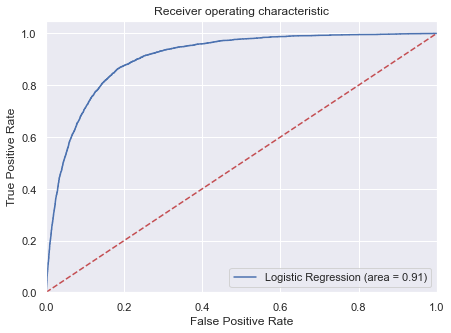

In [33]:
logit_roc_auc_train = roc_auc_score(y_train, lg6.predict(X_train_lg6))
fpr, tpr, thresholds = roc_curve(y_train, lg6.predict(X_train_lg6))
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_train)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

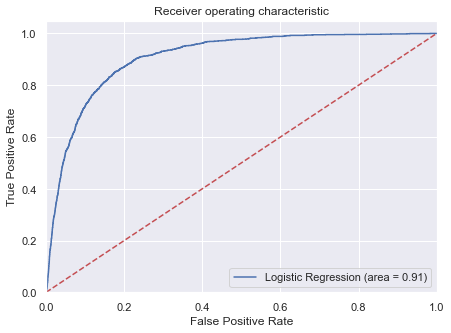

In [34]:
logit_roc_auc_test = roc_auc_score(y_test, lg6.predict(X_test_lg6))
fpr, tpr, thresholds = roc_curve(y_test, lg6.predict(X_test_lg6))
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_test)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Optimal Threshold using precision-recall curve

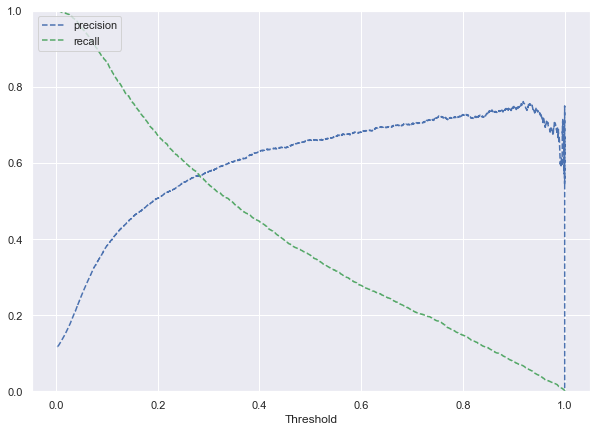

In [35]:
y_scores=lg6.predict(X_train_lg6)
prec, rec, tre = precision_recall_curve(y_train, y_scores,)

def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])
plt.figure(figsize=(10,7))
plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

In [36]:
optimal_threshold = 0.12

pred_train_opt = (lg6.predict(X_train_lg6.astype(float))>optimal_threshold).astype(int)
pred_test_opt = (lg6.predict(X_test_lg6.astype(float))>optimal_threshold).astype(int)

metric_lg_opt = []
metric_lg_opt.append(accuracy_score(y_train, pred_train_opt))
metric_lg_opt.append(accuracy_score(y_test, pred_test_opt))
metric_lg_opt.append(recall_score(y_train, pred_train_opt))
metric_lg_opt.append(recall_score(y_test, pred_test_opt))
metric_lg_opt.append(precision_score(y_train, pred_train_opt))
metric_lg_opt.append(precision_score(y_test, pred_test_opt))

print('Accuracy on train data:', metric_lg_opt[0])
print('Accuracy on test data:', metric_lg_opt[1])

print('Recall on train data:', metric_lg_opt[2])
print('Recall on test data:', metric_lg_opt[3])

print('Precision on train data:', metric_lg_opt[4])
print('Precision on test data:', metric_lg_opt[5])

Accuracy on train data: 0.8450090055929472
Accuracy on test data: 0.8435564730168092
Recall on train data: 0.8190167477039438
Recall on test data: 0.8166351606805293
Precision on train data: 0.4172285674969038
Precision on test data: 0.4144547489606652


#### The recall has greatly improved by using the optimal threshold instead of the default threshold of 0.5. However, the precision has dropped to around 0.4, which is not ideal but overall this is a better model for this problem.

## Decision Trees

In [37]:
y.value_counts(1)

0    0.883015
1    0.116985
Name: y, dtype: float64

In [38]:
dtree = DecisionTreeClassifier(criterion='gini',class_weight={0:0.88,1:0.12},random_state=0)
dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight={0: 0.88, 1: 0.12}, random_state=0)

Accuracy on training set :  1.0
Accuracy on test set :  0.8728988498967856
Recall on training set :  1.0
Recall on test set :  0.5015752993068683
Precision on training set :  1.0
Precision on test set :  0.46038172353961826


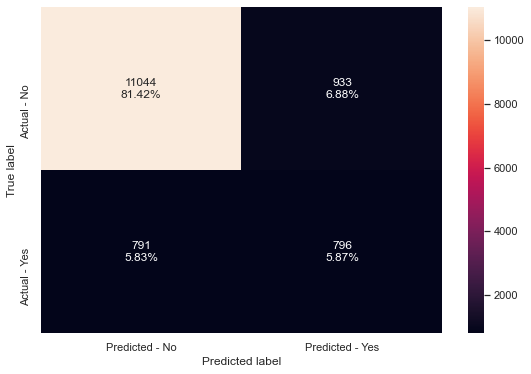

In [39]:
#Calculating different metrics
metric_dt = get_metrics_score(dtree, X_train, X_test, y_train, y_test)

#Creating confusion matrix
make_confusion_matrix(dtree,y_test)

#### There is clear overfitting, and the recall is not too great, neither is precision. We may get better results from tuning later on.

## Random Forest

Accuracy on training set :  1.0
Accuracy on test set :  0.9041580654674137
Recall on training set :  1.0
Recall on test set :  0.38059231253938247
Precision on training set :  1.0
Precision on test set :  0.6558089033659066


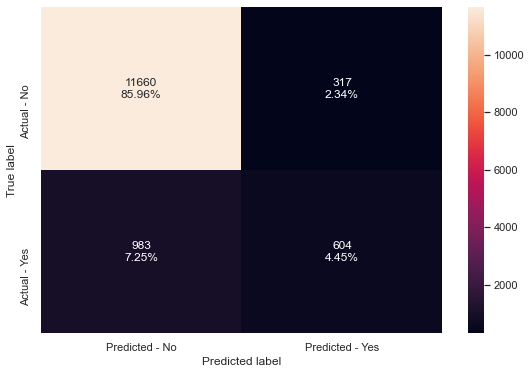

In [40]:
#Fitting the model
rf_estimator = RandomForestClassifier(random_state=1)
rf_estimator.fit(X_train,y_train)

#Calculating different metrics
metric_rf = get_metrics_score(rf_estimator, X_train, X_test, y_train, y_test)

#Creating confusion matrix
make_confusion_matrix(rf_estimator,y_test)

#### Once again there is overfitting, but the recall is even lower, at 0.3, which is very poor.

## Bagging Classifier

Accuracy on training set :  0.9915947799159478
Accuracy on test set :  0.9020937776467118
Recall on training set :  0.9324689357104268
Recall on test set :  0.3982356647763075
Precision on training set :  0.9953863898500577
Precision on test set :  0.6288557213930348


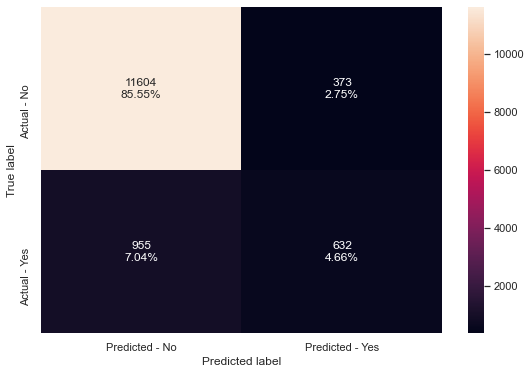

In [41]:
#Fitting the model
bagging_classifier = BaggingClassifier(random_state=1)
bagging_classifier.fit(X_train,y_train)

metric_bgc = get_metrics_score(bagging_classifier, X_train, X_test, y_train, y_test)
make_confusion_matrix(bagging_classifier,y_test)

#### There is lot of overfitting, and once again recall is quite low at 0.4, but accuracy and precision are higher.

## Gradient Boost

Accuracy on training set :  0.9112712105412836
Accuracy on test set :  0.9073282217634916
Recall on training set :  0.4357104267963263
Recall on test set :  0.4158790170132325
Precision on training set :  0.6916809605488851
Precision on test set :  0.6666666666666666


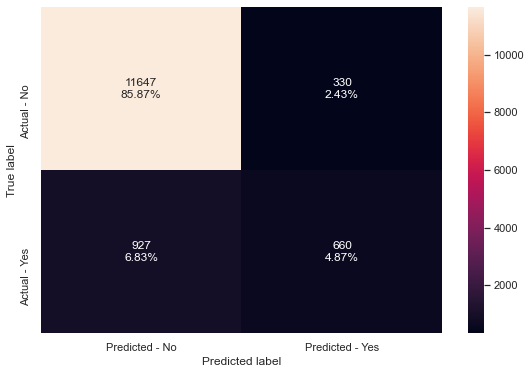

In [42]:
gb_classifier = GradientBoostingClassifier(random_state=1)
gb_classifier.fit(X_train,y_train)

metric_gbc = get_metrics_score(gb_classifier, X_train, X_test, y_train, y_test)
make_confusion_matrix(gb_classifier,y_test)

#### The recall is once again around 0.4, but there is no overfitting in the gradient boost classifier, which is a good sign.

## XG Boost

[23:19:26] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy on training set :  0.9583846810124182
Accuracy on test set :  0.9071807726334414
Recall on training set :  0.731496488384657
Recall on test set :  0.49086326402016384
Precision on training set :  0.8934345100626856
Precision on test set :  0.6333333333333333


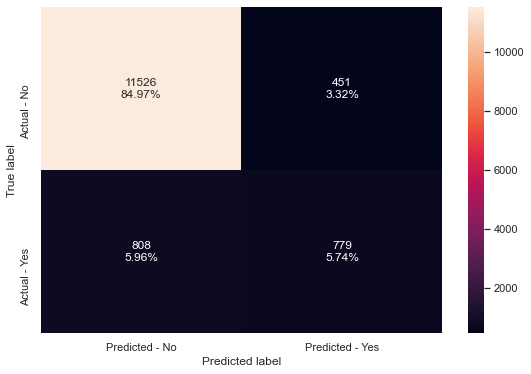

In [43]:
xgb_classifier = XGBClassifier(random_state=1)
xgb_classifier.fit(X_train,y_train)

metric_xgb = get_metrics_score(xgb_classifier, X_train, X_test, y_train, y_test)
make_confusion_matrix(xgb_classifier,y_test)

#### There is some overfitting on the recall and precision, and they both are still quite low.

#### Now I will try to tune the hyperparameters using RandomSearch CV to search for a better model.

## Hyperparameter Tuning

## Tuned Bagging Classifier

In [79]:
# Choose the type of classifier. 
bgc_tuned = BaggingClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {'max_samples': [0.7,0.8,0.9,1], 
              'max_features': [0.7,0.8,0.9,1],
              'n_estimators' : [10,20,30,40,50],
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = RandomizedSearchCV(bgc_tuned, parameters, scoring=scorer,random_state=9)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
bgc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
bgc_tuned.fit(X_train, y_train)

BaggingClassifier(max_features=0.8, max_samples=0.9, n_estimators=30,
                  random_state=1)

Accuracy on training set :  0.9977249028343919
Accuracy on test set :  0.901135358301386
Recall on training set :  0.9805510534846029
Recall on test set :  0.3030875866414619
Precision on training set :  1.0
Precision on test set :  0.6717877094972067


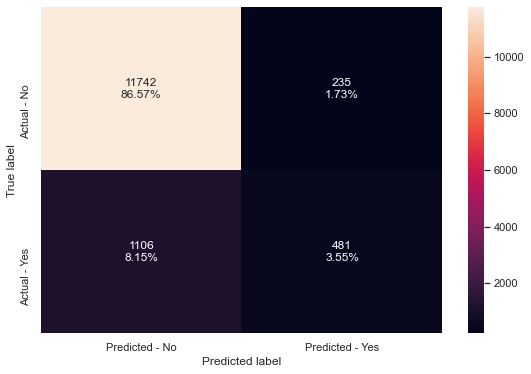

In [80]:
metric_bgc_tuned = get_metrics_score(bgc_tuned, X_train, X_test, y_train, y_test)
make_confusion_matrix(bgc_tuned,y_test)

## Tuned Gradient Boost

In [81]:
# Choose the type of classifier. 
gbc_tuned = GradientBoostingClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {
    "n_estimators": [100,150,200,250],
    "subsample":[0.8,0.9,1],
    "max_features":[0.7,0.8,0.9,1]
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = RandomizedSearchCV(gbc_tuned, parameters, scoring=acc_scorer, random_state=9)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
gbc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
gbc_tuned.fit(X_train, y_train)


GradientBoostingClassifier(max_features=0.7, n_estimators=200, random_state=1,
                           subsample=0.9)

Accuracy on training set :  0.9166745663096028
Accuracy on test set :  0.9074019463285167
Recall on training set :  0.4859535386277688
Recall on test set :  0.43982356647763077
Precision on training set :  0.7102250296091591
Precision on test set :  0.6553990610328638


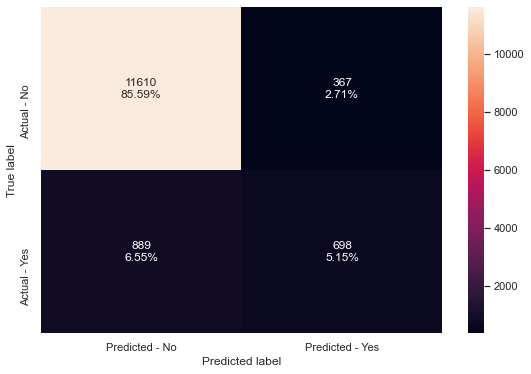

In [82]:
metric_gbc_tuned = get_metrics_score(gbc_tuned, X_train, X_test, y_train, y_test)
make_confusion_matrix(gbc_tuned,y_test)

## Tuned XG Boost

In [77]:
# Choose the type of classifier. 
xgb_tuned = XGBClassifier(random_state=1, eval_metric='logloss')

# Grid of parameters to choose from
parameters = {
    "n_estimators": np.arange(10,80,20),
    "scale_pos_weight":[0,1,2,5],
    "subsample":[0.5,0.7,0.9,1],
    "learning_rate":[0.01,0.1,0.2,0.05],
    "gamma":[0,1,3],
    "colsample_bytree":[0.5,0.7,0.9,1],
    "colsample_bylevel":[0.5,0.7,0.9,1]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = RandomizedSearchCV(xgb_tuned, parameters,scoring=scorer, random_state=9)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=70, n_jobs=4,
              num_parallel_tree=1, random_state=1, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=5, subsample=0.9, tree_method='exact',
              validate_parameters=1, verbosity=None)

Accuracy on training set :  0.8914273074857016
Accuracy on test set :  0.8797552344441167
Recall on training set :  0.8860075634792004
Recall on test set :  0.8254568367989918
Precision on training set :  0.521131236097871
Precision on test set :  0.49174174174174173


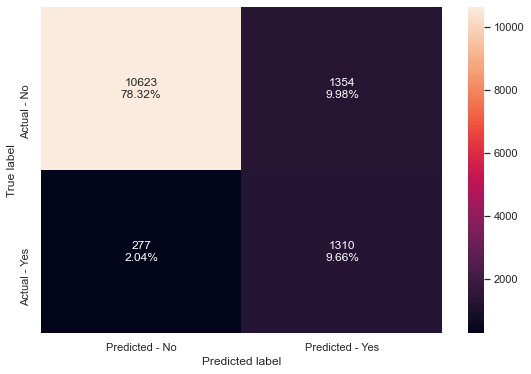

In [89]:
metric_xgb_tuned = get_metrics_score(xgb_tuned, X_train, X_test, y_train, y_test)
make_confusion_matrix(xgb_tuned,y_test)

#### This is a fantastic result in terms of recall. The recall has drastically improved to 0.81 on test set. The precision is low at 0.46, but it is affordable since the main aim is to maximise sales, so if some effort is wasted on customers that will not buy, that is ok.

## Stacking Classifier

In [83]:
estimators = [('Tuned Bagging Classifier',bgc_tuned), ('Tuned Gradient Boosting',gbc_tuned), ('Decision Tree',dtree)]

final_estimator = xgb_tuned

stacking_classifier= StackingClassifier(estimators=estimators,final_estimator=final_estimator)

stacking_classifier.fit(X_train,y_train)

StackingClassifier(estimators=[('Tuned Bagging Classifier',
                                BaggingClassifier(max_features=0.8,
                                                  max_samples=0.9,
                                                  n_estimators=30,
                                                  random_state=1)),
                               ('Tuned Gradient Boosting',
                                GradientBoostingClassifier(max_features=0.7,
                                                           n_estimators=200,
                                                           random_state=1,
                                                           subsample=0.9)),
                               ('Decision Tree',
                                DecisionTreeClassifier(class_weight={0: 0.88,
                                                                     1: 0.12},
                                                       random_state=0))],
                   final_.

Accuracy on training set :  0.9058678547729643
Accuracy on test set :  0.8635358301386021
Recall on training set :  0.9819016747703944
Recall on test set :  0.8393194706994329
Precision on training set :  0.5552161295249732
Precision on test set :  0.45491803278688525


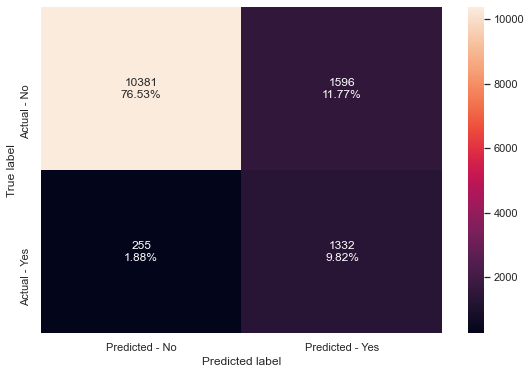

In [84]:
metric_stacking = get_metrics_score(stacking_classifier, X_train, X_test, y_train, y_test)
make_confusion_matrix(stacking_classifier,y_test)

#### The recall is great here too, but there is some overfitting in recall, precision and accuracy. So caution will be needed with this model.

## Model Comparison

In [85]:
# defining list of models
models = [dtree, rf_estimator, bagging_classifier, gb_classifier, xgb_classifier, bgc_tuned,
          gbc_tuned, xgb_tuned, stacking_classifier]

# defining empty lists to add train and test results
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []

# looping through all the models to get the metrics score - Accuracy, Recall and Precision
for model in models:
    
    j = get_metrics_score(model, X_train, X_test, y_train, y_test, False)
    acc_train.append(j[0])
    acc_test.append(j[1])
    recall_train.append(j[2])
    recall_test.append(j[3])
    precision_train.append(j[4])
    precision_test.append(j[5])

In [86]:
# Adding Optimised Logistic Regression scores

acc_train.append(metric_lg_opt[0])
acc_test.append(metric_lg_opt[1])
recall_train.append(metric_lg_opt[2])
recall_test.append(metric_lg_opt[3])
precision_train.append(metric_lg_opt[4])
precision_test.append(metric_lg_opt[5])

In [87]:
comparison = pd.DataFrame({'Model':['Decision Tree', 'Random Forest', 'Bagging Classifier', 'Gradient Boost',
                                    'XGBoost Classifier', 'Tuned Bagging Classifier', 'Tuned Gradient Boost',
                                    'Tuned XGBoost', 'Stacking Classifier', 'Optimised Logistic Regression'], 
                                    'Train_Accuracy': acc_train,'Test_Accuracy': acc_test,
                                    'Train_Recall':recall_train,'Test_Recall':recall_test,
                                    'Train_Precision':precision_train,'Test_Precision':precision_test}) 

#Sorting models in decreasing order of test recall
comparison.sort_values(by='Test_Recall',ascending=False)

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision
8,Stacking Classifier,0.905868,0.863536,0.981902,0.839319,0.555216,0.454918
7,Tuned XGBoost,0.891427,0.879755,0.886008,0.825457,0.521131,0.491742
9,Optimised Logistic Regression,0.845009,0.843556,0.819017,0.816635,0.417229,0.414455
0,Decision Tree,1.000000,0.872899,1.000000,0.501575,1.000000,0.460382
4,XGBoost Classifier,0.958385,0.907181,0.731496,0.490863,0.893435,0.633333
6,Tuned Gradient Boost,0.916675,0.907402,0.485954,0.439824,0.710225,0.655399
3,Gradient Boost,0.911271,0.907328,0.435710,0.415879,0.691681,0.666667
2,Bagging Classifier,0.991595,0.902094,0.932469,0.398236,0.995386,0.628856
1,Random Forest,1.000000,0.904158,1.000000,0.380592,1.000000,0.655809
5,Tuned Bagging Classifier,0.997725,0.901135,0.980551,0.303088,1.000000,0.671788


#### Best Model
#### Based on the test recalls, the highest and best three are the Stacking Classifier and the Tuned XG Boost. However, the Stacking Classifier has some clear overfitting, and the recall score of other two is only slighty lower and precision is similar. The Tuned XG Boost has a better precision, so I will choose the Tuned XG Boost as the best model for the bank to use, as it has a high recall and no overfitting, so it is likely to perform better in production.

## Chosen Model - Tuned XG Boost Classifier

### Metrics

Accuracy on training set :  0.8914273074857016
Accuracy on test set :  0.8797552344441167
Recall on training set :  0.8860075634792004
Recall on test set :  0.8254568367989918
Precision on training set :  0.521131236097871
Precision on test set :  0.49174174174174173


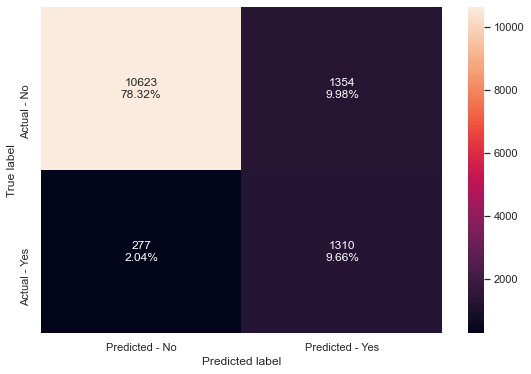

In [88]:
metric_xgb_tuned = get_metrics_score(xgb_tuned, X_train, X_test, y_train, y_test)
make_confusion_matrix(xgb_tuned,y_test)

#### Out of 1587 customers who bought the product, the model correctly identified 1294 customers, which is excellent. It also incorrectly identified 1491 other customers as potential buyers. This is not ideal, but considering the recall score and the number of correct buyers identified, this is totally fine.

### Feature Importance

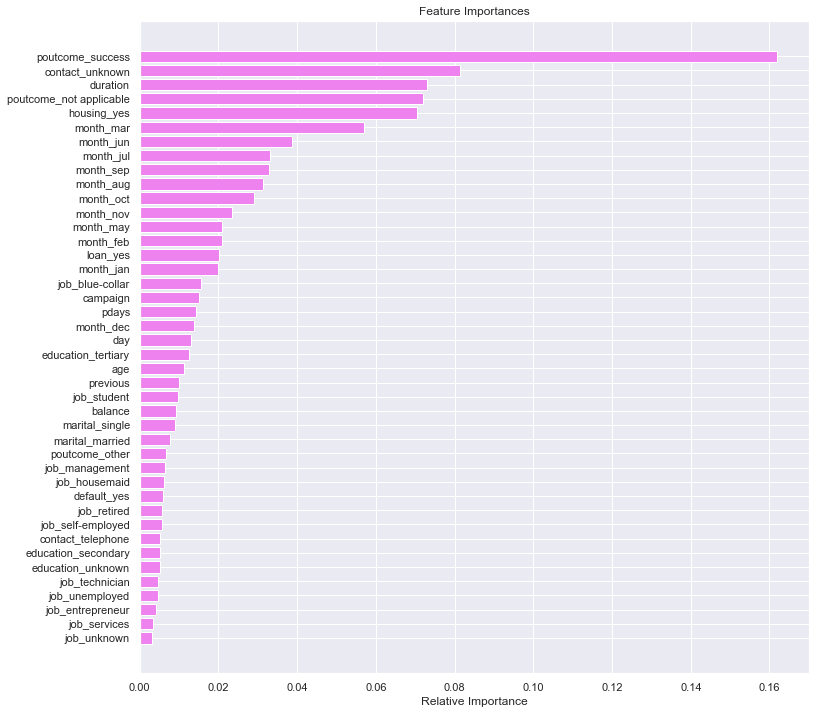

In [90]:
feature_names = X_train.columns
importances = xgb_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### Observations
- As expected, the model considers the outcome of previous campaign as the most important. This was clear in the EDA, where more than 50% of previous buyers bought the term deposit as well. The only issue would be the lack of data since very few customers were actually contacted for a previous campaign.
- The second most important feature is contact_unknown, followed by duration which I am not too sure what the reason is.

# Conclusion

After running several models and tuning hyperparameters, the best model chosen was the tuned XG Boost model.

Some recommendations to the bank are:
- Generally focus on customers that previously bought a product from a campaign.
- Keep in mind that there will be a lot of customers recommended by the model who will not buy in reality, but the model will get as much potential buyers as possible.
- The model can be improved by getting better data, such as average call duration instead of the last one only, how long a customer has been with the bank, etc.
- It would also be useful to segment the customers into groups, and then products can be better tailored and marketed to the customers.